## Notebook Setup

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages

sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [2]:
import re
import json
import itertools
from pathlib import Path
from pprint import pprint
from textwrap import wrap

import krippendorff
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from info_salience.agreement import spearman_rank_correlation

### Utils

In [3]:
rename_model = {
    'OLMo-7B-Instruct-hf': 'OLMo (7B)',
    'OLMo-7B-0724-Instruct-hf': 'OLMo 0724 (7B)',
    'Mistral-7B-Instruct-v0.3': 'Mistral (7B)',
    'Mixtral-8x7B-Instruct-v0.1': 'Mixtral (8x7B)',
    'Llama-2-7b-chat-hf': 'Llama 2 (7B)',
    'Llama-2-13b-chat-hf': 'Llama 2 (13B)',
    'Llama-2-70b-chat-hf': 'Llama 2 (70B)',
    'Meta-Llama-3-8B-Instruct': 'Llama 3 (8B)',
    'Meta-Llama-3-70B-Instruct': 'Llama 3 (70B)',
    'Meta-Llama-3.1-8B-Instruct': 'Llama 3.1 (8B)',
    'Meta-Llama-3.1-70B-Instruct': 'Llama 3.1 (70B)',
    'gpt-4o-mini-2024-07-18': 'GPT-4o-mini (07/24)',
    'gpt-4o-2024-08-06': 'GPT-4o (08/24)'
}

rename_dataset = {
    'pubmed-sample': 'PubMed',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMsum',
}

In [4]:
def pairwise_spearman(raters_a, raters_b=None):
    """
    calculates pairwise spearman rank correlation between two pools of raters
    raters_a and raters_b should be of shape (n_raters, n_items)
    """
    if raters_b is None:
        pairs = itertools.combinations(raters_a, r=2)
    else:
        assert raters_a.shape[1] == raters_b.shape[1]
        pairs = itertools.product(raters_a, raters_b)

    scores = []
    for ratings_a, ratings_b in pairs:
        score = spearman_rank_correlation(ratings_a, ratings_b)
        scores.append(score)
    return scores


a = np.array([
    [2, 5, 4, 3, 4, 5, 2, 2, 3, 2, 4, 3, 4, 4],
    [2, 5, 5, 3, 5, 5, 3, 2, 4, 4, 4, 3, 3, 4],
    [2, 5, 4, 4, 5, 4, 2, 1, 3, 1, 5, 2, 3, 4],
    [2, 4, 4, 3, 5, 5, 3, 3, 1, 5, 4, 2, 3, 4],
    [2, 5, 4, 3, 4, 5, 3, 3, 2, 4, 4, 3, 4, 4]
])

b = np.array([
    [2, 3, 5, 2, 5, 5, 4, 3, 1, 3, 4, 4, 4, 5],
    [3, 5, 5, 4, 4, 5, 2, 2, 4, 4, 5, 1, 2, 2],
    [3, 4, 5, 3, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5],
    [1, 5, 4, 2, 5, 3, 1, 4, 1, 4, 5, 3, 2, 4],
    [3, 5, 2, 4, 5, 5, 1, 1, 3, 1, 2, 1, 2, 2]
])


print('n vs m')
scores = pairwise_spearman(a, b)
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

print('1 vs m')
scores = pairwise_spearman(a[0].reshape(1, -1), b)
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

print('1 vs 1')
scores = pairwise_spearman(a[0].reshape(1, -1), b[0].reshape(1, -1))
print('n comparisons:', len(scores))
print('score', round(np.mean(scores), 3))
print()

n vs m
n comparisons: 25
score 0.533

1 vs m
n comparisons: 5
score 0.524

1 vs 1
n comparisons: 1
score 0.557



In [5]:
def plot_heatmap(df, ax=None, cmap='crest', vmin=None, vmax=None, top=True, labeltop=True, averages=True):
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=(4, 5))      
        
    sns.heatmap(df, annot=True, linewidth=2.5, cmap=cmap, annot_kws={"fontsize":7}, fmt='.2f',ax=ax, vmin=vmin, vmax=vmax)
    ax.collections[0].cmap.set_bad('lightgray')
    ax.tick_params(axis='both', which='both', labelbottom = False, bottom=False, top=top, labeltop=labeltop, labelsize=8)

    if averages:
        # Draw horizontal/vertical lines to set apart the averages
        ax.hlines(df.shape[0]-1, *ax.get_xlim(), colors='black', linewidth=0.5, alpha=0.7)
        ax.vlines(4, *ax.get_ylim(), colors='black', linewidth=0.5, alpha=0.7)
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)

## Data Loading

### LLM-observe

In [6]:
def weights_log_decay(lengths=[10, 20, 50, 100, 200], k=0.02):
    weights = np.exp(-k * np.array(lengths))
    normalized_weights = weights / np.sum(weights)    
    return normalized_weights


def weights_inverse(lengths=[10, 20, 50, 100, 200]):
    return np.array([1/l for l in lengths])


def average_entailment_by_question(run_json):
    df = pd.read_json(run_json)
    df = df.groupby(['doc_id', 'cluster_id'])['summary_200w_nli_pred'].mean().groupby(level=1).mean()
    df = df.reset_index()
    df = df.rename({'cluster_id': 'question_id', 'summary_200w_nli_pred': 'rating'}, axis=1)

    run_path = Path(run_json)
    if "output" in run_path.name:
        # for baselines (random, lead, textrank)
        match = re.match("output-(\d+).json", run_path.name)
        df["variant"] = match.group(1) if match else 0
    else:
        match = re.match(".*temperature([\d\.]+)-(\d+).json", run_path.name)
        df["variant"] = int(match.group(2))
        
    df['rater'] = run_path.parents[1].name
    df['dataset'] = run_path.parents[2].name
    return df[['dataset', 'rater', 'variant', 'question_id', 'rating']]


def load_all_ratings_length_salience():
    runs = []
    for dataset in ['pubmed-sample', 'cs-cl', 'astro-ph', 'qmsum-generic']:
        # get models in this dataset with temperature 0.3
        paths = list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/temperature0.3-*.json'))
        paths += list(Path(f'../output/{dataset}/').glob('**/discord-qa-nli/output*.json'))
        for p in paths:
            model = p.parents[1].name
            runs.append((dataset, model, p))
    df_runs = pd.DataFrame(runs, columns=['dataset', 'model', 'run'])        
    df_runs = df_runs[~df_runs['model'].str.contains('quantized')]
    
    dfs = []
    for index, row in tqdm(df_runs.iterrows(), total=len(df_runs)):
        df_model_ratings = average_entailment_by_question(row['run'])
        dfs.append(df_model_ratings)
        
    df_ratings_llm_length = pd.concat(dfs, ignore_index=True)
    return df_ratings_llm_length

In [7]:
average_entailment_by_question('../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-0.json')

,dataset,rater,variant,question_id,rating
0,pubmed-sample,gpt-4o-2024-08-06,0,0,0.788991
1,pubmed-sample,gpt-4o-2024-08-06,0,1,0.943478
2,pubmed-sample,gpt-4o-2024-08-06,0,2,0.541979
3,pubmed-sample,gpt-4o-2024-08-06,0,3,0.721512
4,pubmed-sample,gpt-4o-2024-08-06,0,4,0.848677
5,pubmed-sample,gpt-4o-2024-08-06,0,6,0.766436
6,pubmed-sample,gpt-4o-2024-08-06,0,8,0.774925
7,pubmed-sample,gpt-4o-2024-08-06,0,9,0.880896
8,pubmed-sample,gpt-4o-2024-08-06,0,10,0.885802
9,pubmed-sample,gpt-4o-2024-08-06,0,11,0.881931


In [8]:
df_llm_observed = load_all_ratings_length_salience()
df_llm_observed.head()

  0%|          | 0/254 [00:00<?, ?it/s]

,dataset,rater,variant,question_id,rating
0,pubmed-sample,gpt-4o-mini-2024-07-18,1,0,0.681000
1,pubmed-sample,gpt-4o-mini-2024-07-18,1,1,0.931260
2,pubmed-sample,gpt-4o-mini-2024-07-18,1,2,0.530293
3,pubmed-sample,gpt-4o-mini-2024-07-18,1,3,0.671625
4,pubmed-sample,gpt-4o-mini-2024-07-18,1,4,0.823568


### LLM-perceive

In [9]:
def load_ratings(ratings_path):
    ratings_path = Path(ratings_path)
    model = ratings_path.parents[1].name
    dataset = ratings_path.parents[2].name
    
    with open(ratings_path) as fin:
        ratings = json.load(fin)

    rated_questions = []
    for question in ratings:
        for i in range(5):
            rated_questions.append({
                'question_id': question['cluster_id'],
                'variant': i,
                'rating': question[f'rating{i}'],
                'rationale': question.get(f'rationale{i}', '')
            })

    df = pd.DataFrame(rated_questions)
    df['dataset'] = dataset
    df['rater'] = model
    return df


def load_all_ratings():
    paths = list(sorted(Path('../output/').glob('**/**/introspection-rationale/generic.json')))
    df = pd.concat([
        load_ratings(path)
        for path in paths
    ], ignore_index=True)
    df = df[['dataset', 'rater', 'variant', 'question_id', 'rating', 'rationale']]
    return df

In [10]:
df_llm_perceived = load_all_ratings()

print('drop n/a')
na_mask = df_llm_perceived['rating'].isna()
display(df_llm_perceived[na_mask].groupby(['dataset', 'rater', 'variant']).size().unstack())
df_llm_perceived = df_llm_perceived[~na_mask]

#######################
# Add a random rater
#######################
np.random.seed(42)
repeats = 5
random_rater = []
for dataset, question_ids in df_llm_perceived.groupby('dataset')['question_id'].unique().items():
    for i in range(repeats):
        ratings = np.random.randint(1,5,len(question_ids))
        for question_id, rating in zip(question_ids, ratings):
            random_rater.append({
                'dataset': dataset,
                'rater': 'random',
                'variant': i,
                'question_id': question_id,
                'rating': rating
            })  
df_random_rater = pd.DataFrame(random_rater)    
df_llm_perceived = pd.concat([df_llm_perceived, df_random_rater], ignore_index=True)
df_llm_perceived.head()

drop n/a


,variant,4
dataset,rater,
astro-ph,OLMo-7B-Instruct-hf,13


,dataset,rater,variant,question_id,rating,rationale
0,astro-ph,Llama-2-13b-chat-hf,0,0,5,This question is important to provide a clear ...
1,astro-ph,Llama-2-13b-chat-hf,1,0,4,This question is important to provide context ...
2,astro-ph,Llama-2-13b-chat-hf,2,0,4,This question is important to provide context ...
3,astro-ph,Llama-2-13b-chat-hf,3,0,4,This question is important as it provides a hi...
4,astro-ph,Llama-2-13b-chat-hf,4,0,5,This question is crucial to provide a clear ov...


### Humans-perceive

In [11]:
def load_human_ratings():
    items = []
    
    for json_file in Path('../data/annotations/human-salience/').glob('*.json'):
        print('Loading:', json_file)
        
        with open(json_file) as fin:
            data = json.load(fin)
        
        for item in data['items']:
            items.append({
                'dataset': data['dataset'],
                'rater': data['annotator'],
                'variant': 0,  # to align with other analysis where we sometimes have multiple ratings for the same rater
                'question_id': item['id'],
                'rating': item['rating'],
                'rationale': item['rationale']
            })
    
    df_ratings = pd.DataFrame(items)
    return df_ratings

In [12]:
df_humans = load_human_ratings()
df_humans.head()

Loading: ../data/annotations/human-salience/astro-ph-1dre2sz.json
Loading: ../data/annotations/human-salience/cs-cl-fd6d95de.json
Loading: ../data/annotations/human-salience/astro-ph-fgmyyll.json
Loading: ../data/annotations/human-salience/qmsum-generic-06r6zhf.json
Loading: ../data/annotations/human-salience/cs-cl-ihvb1io.json
Loading: ../data/annotations/human-salience/pubmed-sample-1gxc5yr.json
Loading: ../data/annotations/human-salience/pubmed-sample-a4pjhcl.json
Loading: ../data/annotations/human-salience/cs-cl-m0vrw0r.json
Loading: ../data/annotations/human-salience/qmsum-generic-qcpmyok.json
Loading: ../data/annotations/human-salience/astro-ph-t39hhaf.json
Loading: ../data/annotations/human-salience/cs-cl-06r6zhf.json
Loading: ../data/annotations/human-salience/astro-ph-22ed0lh.json
Loading: ../data/annotations/human-salience/qmsum-generic-kol9cy5.json
Loading: ../data/annotations/human-salience/pubmed-sample-j42q3qe.json
Loading: ../data/annotations/human-salience/astro-ph-54zn

,dataset,rater,variant,question_id,rating,rationale
0,astro-ph,1dre2sz,0,3,1,Based on the provided examples I most likely d...
1,astro-ph,1dre2sz,0,9,1,"The future direction, IMO, should not be inclu..."
2,astro-ph,1dre2sz,0,12,2,"In some cases, we describe the technique or mo..."
3,astro-ph,1dre2sz,0,2,4,I think interpretation and implications of the...
4,astro-ph,1dre2sz,0,6,3,Comparison in this context can have three mean...


### Combine all

In [13]:
df_ratings = pd.concat([
    df_llm_observed.assign(group='llm_observed'),
    df_llm_perceived.assign(group='llm_perceived'),
    df_humans.assign(group='humans'),
])
df_ratings.head()

,dataset,rater,variant,question_id,rating,group,rationale
0,pubmed-sample,gpt-4o-mini-2024-07-18,1,0,0.681,llm_observed,NaN
1,pubmed-sample,gpt-4o-mini-2024-07-18,1,1,0.93126,llm_observed,NaN
2,pubmed-sample,gpt-4o-mini-2024-07-18,1,2,0.530293,llm_observed,NaN
3,pubmed-sample,gpt-4o-mini-2024-07-18,1,3,0.671625,llm_observed,NaN
4,pubmed-sample,gpt-4o-mini-2024-07-18,1,4,0.823568,llm_observed,NaN


## Visualize raw ratings

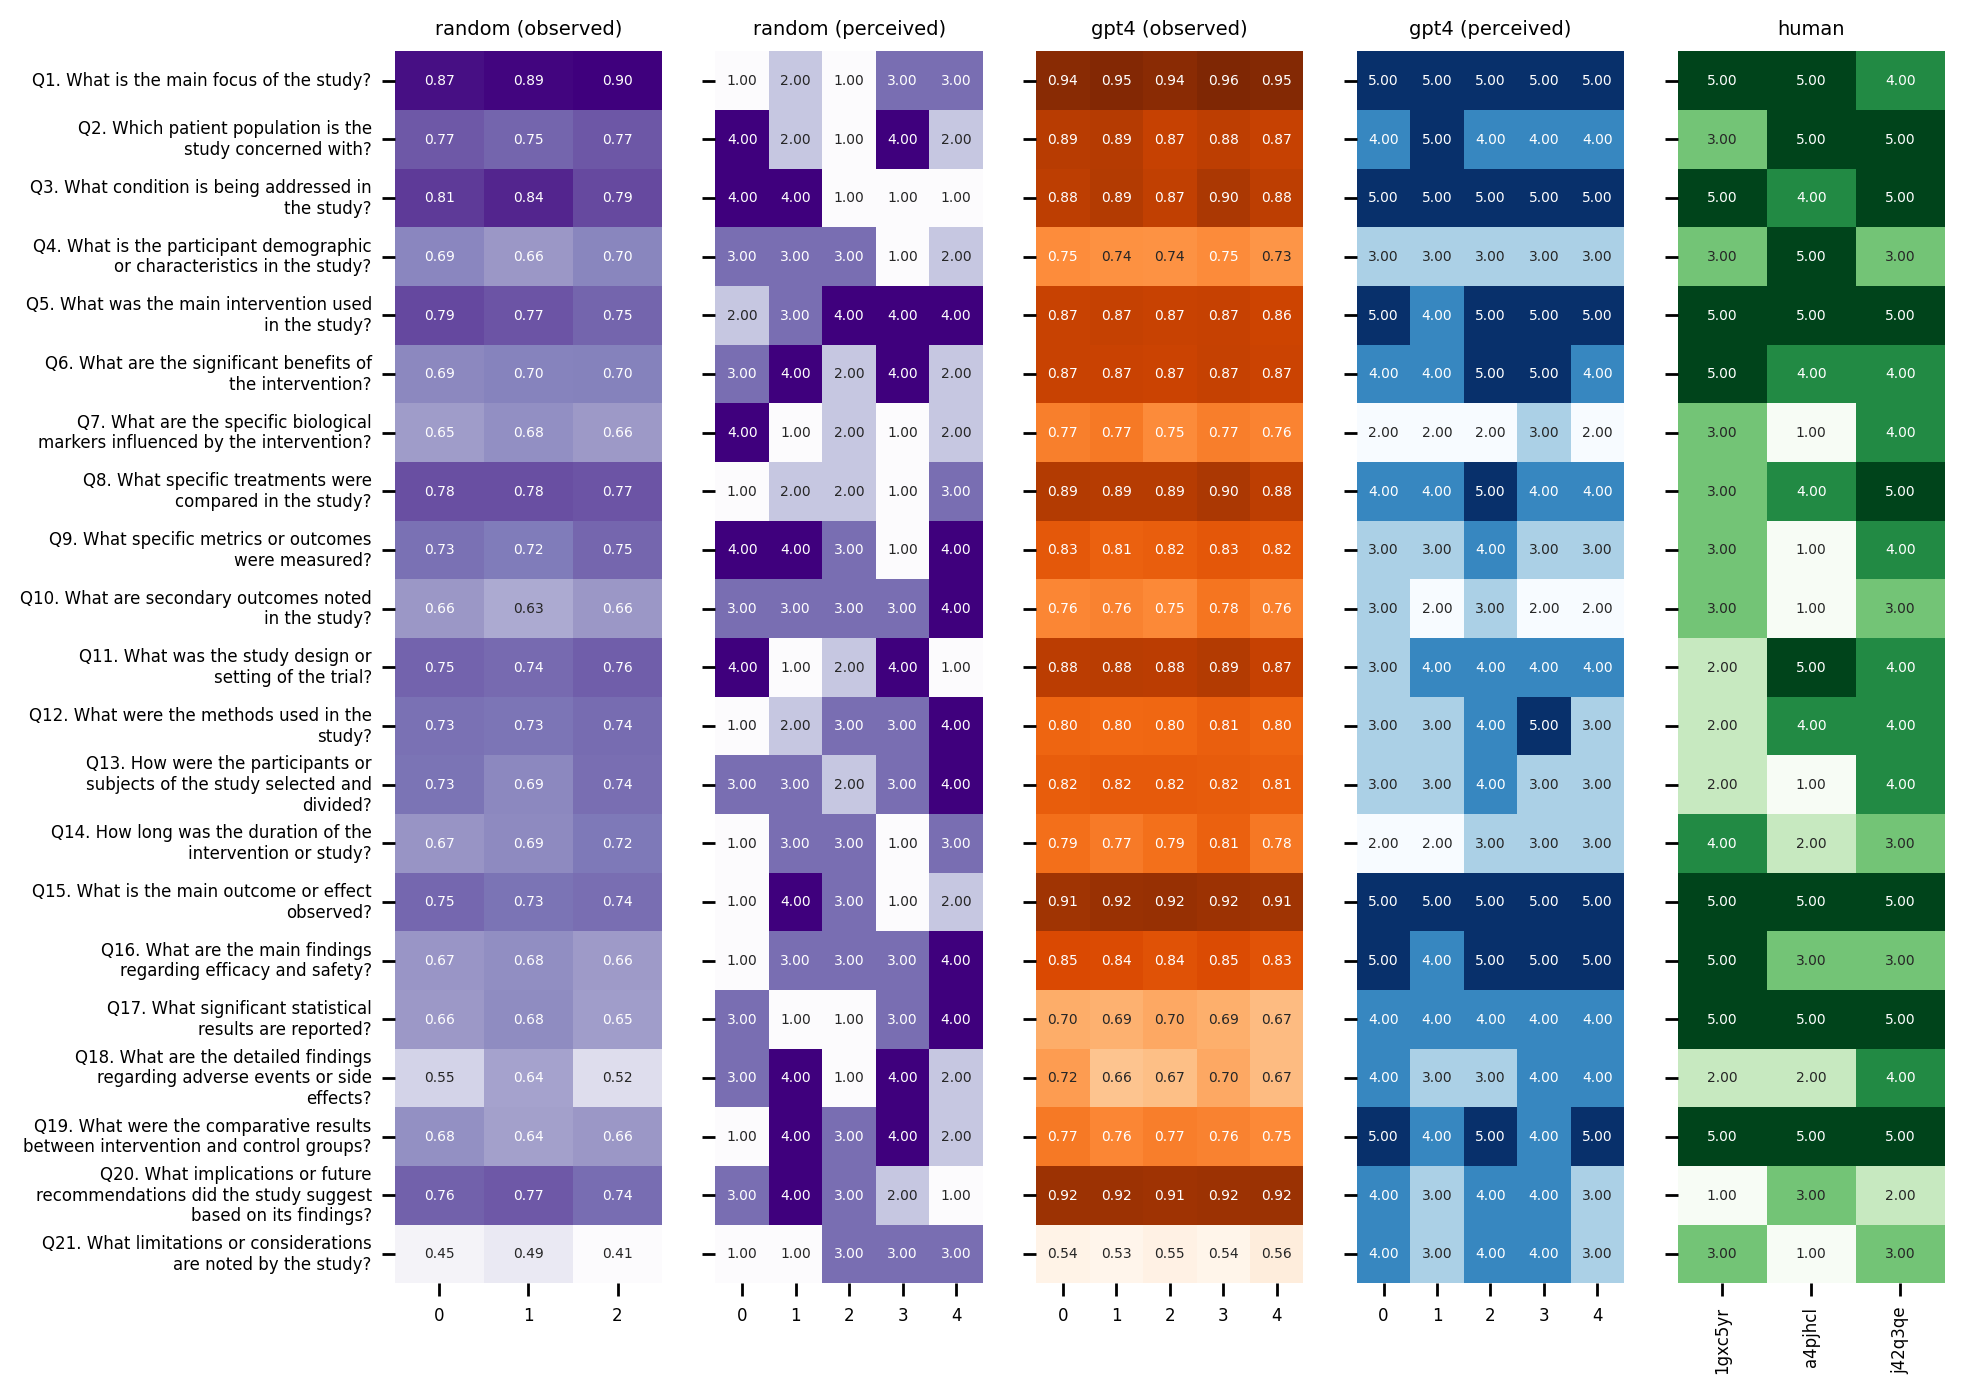

In [14]:
dataset = 'pubmed-sample'

random_observed = df_ratings[
    (df_ratings['dataset'] == dataset) 
    & (df_ratings['group'] == 'llm_observed')
    & (df_ratings['rater'] == 'random')
].pivot(index='question_id', columns='variant', values='rating').astype(float)

random_perceived = df_ratings[
    (df_ratings['dataset'] == dataset) 
    & (df_ratings['group'] == 'llm_perceived')
    & (df_ratings['rater'] == 'random')
].pivot(index='question_id', columns='variant', values='rating').astype(int)


gpt4_observed = df_ratings[
    (df_ratings['dataset'] == dataset) 
    & (df_ratings['group'] == 'llm_observed')
    & (df_ratings['rater'] == 'gpt-4o-2024-08-06')
].pivot(index='question_id', columns='variant', values='rating').astype(float)

gpt4_perceived = df_ratings[
    (df_ratings['dataset'] == dataset) 
    & (df_ratings['group'] == 'llm_perceived')
    & (df_ratings['rater'] == 'gpt-4o-2024-08-06')
].pivot(index='question_id', columns='variant', values='rating').astype(int)

human = df_ratings[
    (df_ratings['dataset'] == dataset) 
    & (df_ratings['group'] == 'humans')
].pivot(index='question_id', columns='rater', values='rating').astype(int)

dfs = [random_observed, random_perceived, gpt4_observed, gpt4_perceived, human]
titles = ['random (observed)', 'random (perceived)', 'gpt4 (observed)', 'gpt4 (perceived)', 'human']
cmaps = ['Purples', 'Purples', 'Oranges', 'Blues', 'Greens']

df_questions = pd.read_json(f'../output/{dataset}/discord_questions.json')
df_questions = df_questions.rename({'cluster_id': 'question_id', 'centroid': 'question'}, axis=1)
df_questions = df_questions.sort_values('group_id')
order = df_questions['question_id'].values
rename_questions = df_questions.set_index(['question_id'])['question'].to_dict()
dfs = [df.loc[order].rename(index=rename_questions) for df in dfs]

ylabels = dfs[0].index
ylabels_wrapped= [
    '\n'.join(wrap(f'Q{i+1}. {label}', width=40)) 
    for i, label in enumerate(ylabels)
]

fig, axes = plt.subplots(1, len(dfs), figsize=(10,8), sharey=True)
for i, (df, title, cmap) in enumerate(zip(dfs, titles, cmaps)):
    ax = axes[i]
    sns.heatmap(df, ax=ax, cmap=cmap, cbar=False, annot=True, annot_kws={'fontsize': 5}, fmt=".2f")
    ax.set_yticklabels(ylabels_wrapped)
    ax.tick_params(labelsize=6, axis='both')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(title, fontsize=7)

## Consistency of salience estimates

### Humans

In [15]:
def human_human_agreement(dataset):
    ratings = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'humans')
    ].pivot(index='rater', columns='question_id', values='rating')
    scores = pairwise_spearman(ratings.values)
    return scores

In [16]:
datasets = ['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']

stats = []
for dataset in datasets:
    scores = human_human_agreement(dataset)
    stats.append({
        'dataset': dataset,
        'mean': np.mean(scores),
        'std': np.std(scores),
        'raw': scores
    })

df_human_human = pd.DataFrame(stats)
df_human_human

,dataset,mean,std,raw
0,pubmed-sample,0.462725,0.058437,"[0.420428699312069, 0.4223854239387988, 0.5453..."
1,astro-ph,0.160525,0.443531,"[0.6280025089999468, 0.12769128322743264, 0.58..."
2,cs-cl,0.261345,0.286056,"[0.07719430243429481, 0.797844528237595, 0.430..."
3,qmsum-generic,0.602703,0.176661,"[0.6982972487551756, 0.7800284895082003, 0.806..."


In [17]:
df = df_human_human.set_index('dataset')
df['annotators'] = df_ratings[df_ratings['group'] == 'humans'].groupby('dataset')['rater'].nunique()
df['questions'] = df_ratings[df_ratings['group'] == 'humans'].groupby('dataset')['question_id'].nunique()
df = df.rename(index=rename_dataset)
df = df.reset_index()
df = df[['dataset', 'questions', 'annotators', 'mean', 'std']]
df = df.rename({
    'dataset': 'Dataset',
    'questions': 'Questions',
    'annotators': 'Raters',
    'mean': 'Spearman',
    'std': 'Std.',
}, axis=1)
df = df.sort_values('Spearman', ascending=False)
tex = df \
    .set_index('Dataset') \
    .style \
    .format(precision=2) \
    .map_index(lambda v: "font-weight: bold;", axis="columns") \
    .to_latex(
        environment='table',
        position_float='centering',
        position='h',
        hrules=True,
        convert_css=True
    )
tex = tex.replace('\\centering', '\\small\n\\centering')
print(tex)

\begin{table}[h]
\small
\centering
\begin{tabular}{lrrrr}
\toprule
 & \bfseries Questions & \bfseries Raters & \bfseries Spearman & \bfseries Std. \\
Dataset &  &  &  &  \\
\midrule
QMsum & 10 & 5 & 0.60 & 0.18 \\
PubMed & 21 & 3 & 0.46 & 0.06 \\
CL & 14 & 5 & 0.26 & 0.29 \\
Astro & 13 & 5 & 0.16 & 0.44 \\
\bottomrule
\end{tabular}
\end{table}



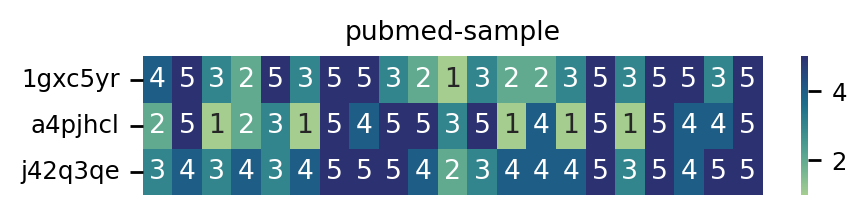

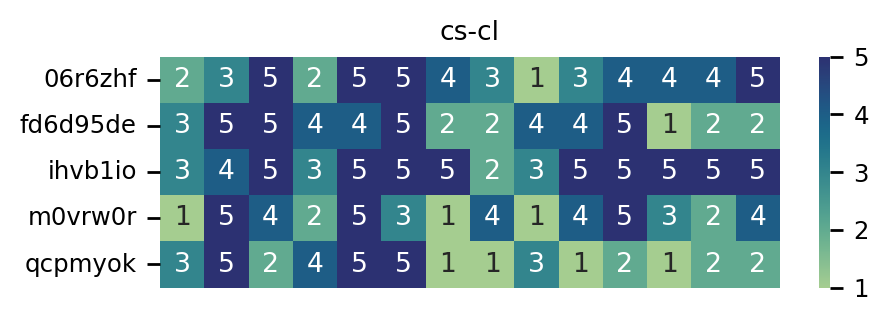

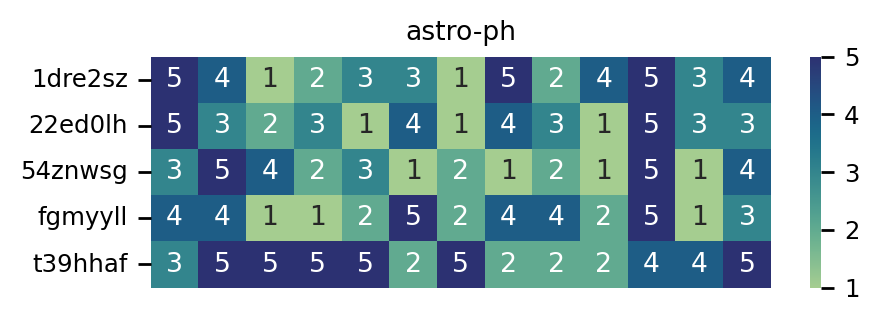

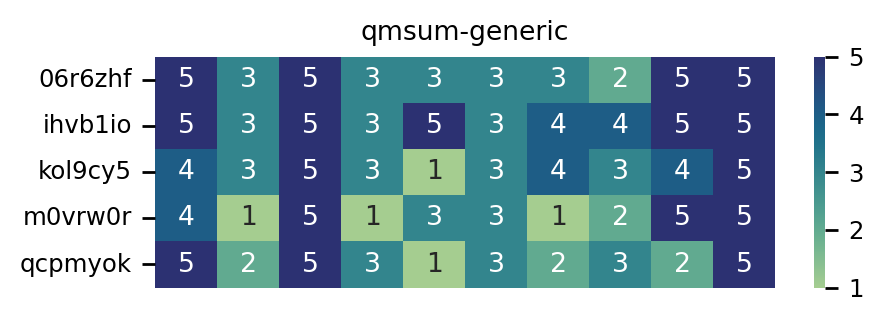

In [18]:
datasets = df_ratings['dataset'].unique()
for dataset in datasets:
    df = df_ratings[
        (df_ratings['group'] == 'humans')
        & (df_ratings['dataset'] == dataset)
    ].copy()
    df['rating'] = df['rating'].astype(float)
    df = df.pivot(index='rater', columns='question_id', values='rating')
    
    n_annotators = len(df)
    plt.figure(figsize=(5, 0.3*n_annotators))
    ax = sns.heatmap(df, annot=True, cmap='crest')
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_title(dataset)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_visible(False)
    plt.show()

### LLM-observed

In [19]:
def observed_observed_agreement(dataset, rater):
    ratings = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['rater'] == rater)    
        & (df_ratings['group'] == 'llm_observed')
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')
    scores = pairwise_spearman(ratings.values)
    return scores
    

datasets = ['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']
raters = df_ratings[df_ratings['group'] == 'llm_observed']['rater'].unique()

stats = []
for dataset, rater in itertools.product(datasets, raters):
    scores = observed_observed_agreement(dataset, rater)
    if not scores:
        print('n/a', dataset, rater)
        continue
        
    stats.append({
        'dataset': dataset,
        'rater': rater,
        'mean': np.mean(scores),
        'std': np.std(scores),
        'raw': scores
    })

df_llm_observed_self = pd.DataFrame(stats)
df_llm_observed_self.head()

n/a pubmed-sample lead_1
n/a pubmed-sample greedy
n/a pubmed-sample textrank
n/a pubmed-sample lead_n
n/a astro-ph lead_1
n/a astro-ph greedy
n/a astro-ph textrank
n/a astro-ph lead_n
n/a cs-cl lead_1
n/a cs-cl greedy
n/a cs-cl textrank
n/a cs-cl lead_n
n/a qmsum-generic Meta-Llama-3-8B-Instruct
n/a qmsum-generic Llama-2-13b-chat-hf
n/a qmsum-generic Meta-Llama-3-70B-Instruct
n/a qmsum-generic Llama-2-70b-chat-hf
n/a qmsum-generic OLMo-7B-Instruct-hf
n/a qmsum-generic Llama-2-7b-chat-hf
n/a qmsum-generic OLMo-7B-0724-Instruct-hf
n/a qmsum-generic gpt-4o-2024-08-06
n/a qmsum-generic lead_1
n/a qmsum-generic greedy
n/a qmsum-generic textrank
n/a qmsum-generic lead_n


,dataset,rater,mean,std,raw
0,pubmed-sample,gpt-4o-mini-2024-07-18,0.986494,0.004544,"[0.9818181818181818, 0.9779220779220777, 0.985..."
1,pubmed-sample,Mixtral-8x7B-Instruct-v0.1,0.986494,0.004544,"[0.9935064935064933, 0.9844155844155844, 0.984..."
2,pubmed-sample,Meta-Llama-3-8B-Instruct,0.980779,0.006591,"[0.9909090909090909, 0.9792207792207792, 0.987..."
3,pubmed-sample,Llama-2-13b-chat-hf,0.981039,0.011820,"[0.9753246753246754, 0.9532467532467532, 0.974..."
4,pubmed-sample,Meta-Llama-3-70B-Instruct,0.982208,0.007772,"[0.9844155844155844, 0.9766233766233766, 0.963..."


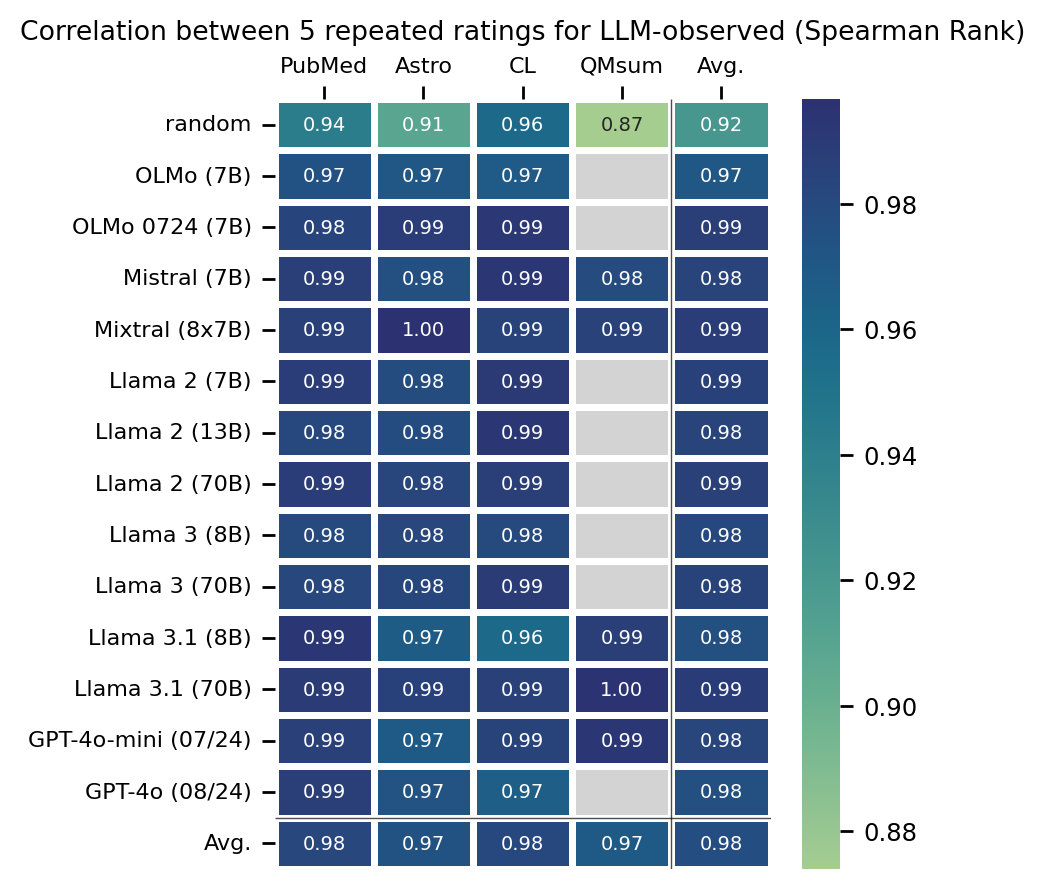

In [20]:
df = df_llm_observed_self.pivot(index='rater', columns='dataset', values='mean')
df = df.loc[['random'] + list(rename_model.keys())][rename_dataset.keys()]
df = df.rename(rename_dataset, axis=1)
df = df.rename(index=rename_model)
df.loc['Avg.'] = df.mean(axis=0)
df['Avg.'] = df.mean(axis=1)

plot_heatmap(df)
plt.title('Correlation between 5 repeated ratings for LLM-observed (Spearman Rank)');

### LLM-perceived

In [21]:
def perceived_perceived_agreement(dataset, rater):
    ratings = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'llm_perceived')
        & (df_ratings['rater'] == rater)
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')
    
    if ratings.empty:
        return None
        
    scores = pairwise_spearman(ratings.values)
    return scores
    

datasets = ['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']
raters = df_ratings[df_ratings['group'] == 'llm_perceived']['rater'].unique()

stats = []
for dataset, rater in itertools.product(datasets, raters):
    scores = perceived_perceived_agreement(dataset, rater)
    if not scores:
        print('n/a', dataset, rater)
        continue
        
    stats.append({
        'dataset': dataset,
        'rater': rater,
        'mean': np.mean(scores),
        'std': np.std(scores),
        'raw': scores
    })

df_llm_perceived_self = pd.DataFrame(stats)
df_llm_perceived_self.head()

/home/trienes/info-salience/src/info_salience/agreement.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(x1, x2)


,dataset,rater,mean,std,raw
0,pubmed-sample,Llama-2-13b-chat-hf,0.493191,0.226018,"[0.7219073890002342, 0.6663344964277088, 0.425..."
1,pubmed-sample,Llama-2-70b-chat-hf,0.192662,0.226646,"[0.016853081547479366, -0.344505007288631, 0.2..."
2,pubmed-sample,Llama-2-7b-chat-hf,0.113562,0.395195,"[0.48530103277151904, 0.42336510930563076, 0.3..."
3,pubmed-sample,Meta-Llama-3-70B-Instruct,0.709196,0.068945,"[0.6198607813065029, 0.7782473386848406, 0.756..."
4,pubmed-sample,Meta-Llama-3-8B-Instruct,0.521994,0.133375,"[0.2668972902949168, 0.4331557821661067, 0.430..."


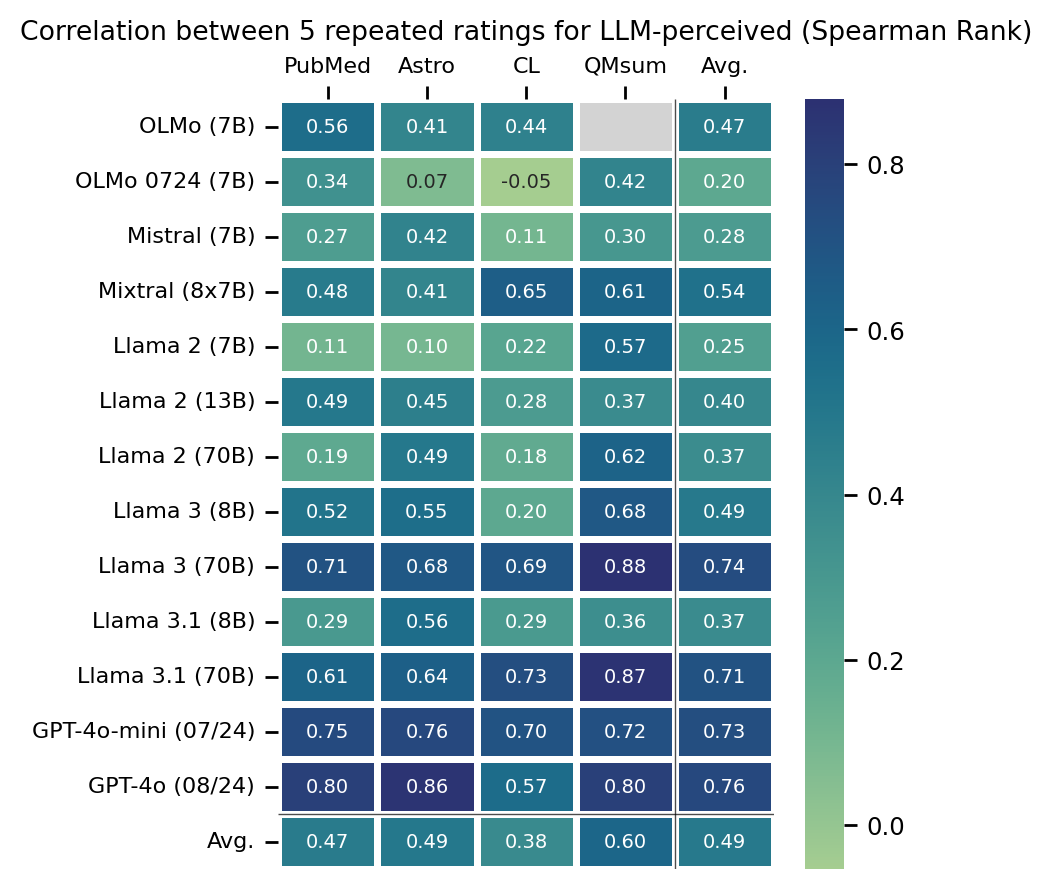

In [22]:
df = df_llm_perceived_self.pivot(index='rater', columns='dataset', values='mean')
df = df.loc[rename_model.keys()][rename_dataset.keys()]
df = df.rename(rename_dataset, axis=1)
df = df.rename(index=rename_model)
df.loc['Avg.'] = df.mean(axis=0)
df['Avg.'] = df.mean(axis=1)

plot_heatmap(df)
plt.title('Correlation between 5 repeated ratings for LLM-perceived (Spearman Rank)');

## Correlation of salience estimates (LLM-observed vs. LLM-perceived)

In [23]:
def llm_observed_vs_perceived(dataset, rater):
    ratings_observed = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'llm_observed')
        & (df_ratings['rater'] == rater) 
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')

    ratings_perceived = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'llm_perceived')
        & (df_ratings['rater'] == rater) 
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')

    if ratings_observed.empty or ratings_perceived.empty:
        return None

    scores = pairwise_spearman(ratings_observed.values, ratings_perceived.values)
    return scores

In [24]:
datasets = df_ratings['dataset'].unique()
raters = df_ratings[df_ratings['group'].isin(['llm_observed', 'llm_perceived'])]['rater'].unique()

stats = []
for dataset, rater in itertools.product(datasets, raters):
    scores = llm_observed_vs_perceived(dataset, rater)

    if not scores:
        print(f'n/a:', (dataset, rater))
        continue
    else:
        stats.append({
            'dataset': dataset,
            'rater': rater,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'raw': scores
        })

df_llm_observed_vs_perceived = pd.DataFrame(stats)
df_llm_observed_vs_perceived.head()

n/a: ('pubmed-sample', 'lead_1')
n/a: ('pubmed-sample', 'greedy')
n/a: ('pubmed-sample', 'textrank')
n/a: ('pubmed-sample', 'lead_n')
n/a: ('cs-cl', 'lead_1')
n/a: ('cs-cl', 'greedy')
n/a: ('cs-cl', 'textrank')
n/a: ('cs-cl', 'lead_n')
n/a: ('astro-ph', 'lead_1')
n/a: ('astro-ph', 'greedy')
n/a: ('astro-ph', 'textrank')
n/a: ('astro-ph', 'lead_n')
n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-generic', 'Llama-2-70b-chat-hf')
n/a: ('qmsum-generic', 'OLMo-7B-Instruct-hf')
n/a: ('qmsum-generic', 'Llama-2-7b-chat-hf')
n/a: ('qmsum-generic', 'OLMo-7B-0724-Instruct-hf')
n/a: ('qmsum-generic', 'gpt-4o-2024-08-06')
n/a: ('qmsum-generic', 'lead_1')
n/a: ('qmsum-generic', 'greedy')
n/a: ('qmsum-generic', 'textrank')
n/a: ('qmsum-generic', 'lead_n')


,dataset,rater,mean,std,raw
0,pubmed-sample,gpt-4o-mini-2024-07-18,0.409450,0.166960,"[0.6368091132374892, 0.21870472036847755, 0.31..."
1,pubmed-sample,Mixtral-8x7B-Instruct-v0.1,0.250210,0.126515,"[0.19131018425475052, 0.1365638067280581, 0.14..."
2,pubmed-sample,Meta-Llama-3-8B-Instruct,0.367837,0.206619,"[0.1463373582330309, 0.43584847534130855, 0.47..."
3,pubmed-sample,Llama-2-13b-chat-hf,0.432155,0.236099,"[0.25400806866843895, 0.5818491024560385, 0.60..."
4,pubmed-sample,Meta-Llama-3-70B-Instruct,0.374082,0.149348,"[0.521683549020172, 0.16543700161283206, 0.486..."


## Correlation with human salience

### LLM-perceived vs. human

In [25]:
def llm_perceived_vs_human(dataset, model):
    ratings_human =  df_ratings[(df_ratings['dataset'] == dataset) & (df_ratings['group'] == 'humans')].pivot(index='rater', columns='question_id', values='rating')
    ratings_model = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'llm_perceived')
        & (df_ratings['rater'] == model) 
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')

    if ratings_model.empty:
        return None
    
    scores = pairwise_spearman(ratings_human.values, ratings_model.values)
    return scores

In [26]:
filtered = df_ratings[(df_ratings['group'] == 'llm_perceived')]
datasets = filtered['dataset'].unique()
raters = filtered['rater'].unique()

stats = []
for dataset, rater in itertools.product(datasets, raters):
    scores = llm_perceived_vs_human(dataset, rater)

    if not scores:
        print(f'n/a:', (dataset, rater))
        continue

    if any(np.isnan(scores)) and not all(np.isnan(scores)):
        print(f'has numeric problem: {dataset} {rater}')
        mean = np.nanmean(scores)
    else:
        mean = np.mean(scores)
    
    
    stats.append({
        'dataset': dataset,
        'rater': rater,
        'mean': mean,
        'std': np.std(scores),
        'raw': scores
    })

df_llm_perceived_vs_human = pd.DataFrame(stats)
df_llm_perceived_vs_human.head()

has numeric problem: qmsum-generic OLMo-7B-Instruct-hf


/home/trienes/info-salience/src/info_salience/agreement.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(x1, x2)


,dataset,rater,mean,std,raw
0,astro-ph,Llama-2-13b-chat-hf,0.269828,0.230630,"[0.1703200768301511, 0.27576569869188305, 0.36..."
1,astro-ph,Llama-2-70b-chat-hf,0.257063,0.192556,"[0.09860636027008748, 0.3400156910996955, 0.25..."
2,astro-ph,Llama-2-7b-chat-hf,0.079179,0.268617,"[0.7359800721939872, 0.19124250611494484, -0.0..."
3,astro-ph,Meta-Llama-3-70B-Instruct,0.413404,0.188387,"[0.4478731250415164, 0.38993814872921645, 0.53..."
4,astro-ph,Meta-Llama-3-8B-Instruct,0.331323,0.271090,"[0.32224716664325864, 0.1853743141959974, 0.03..."


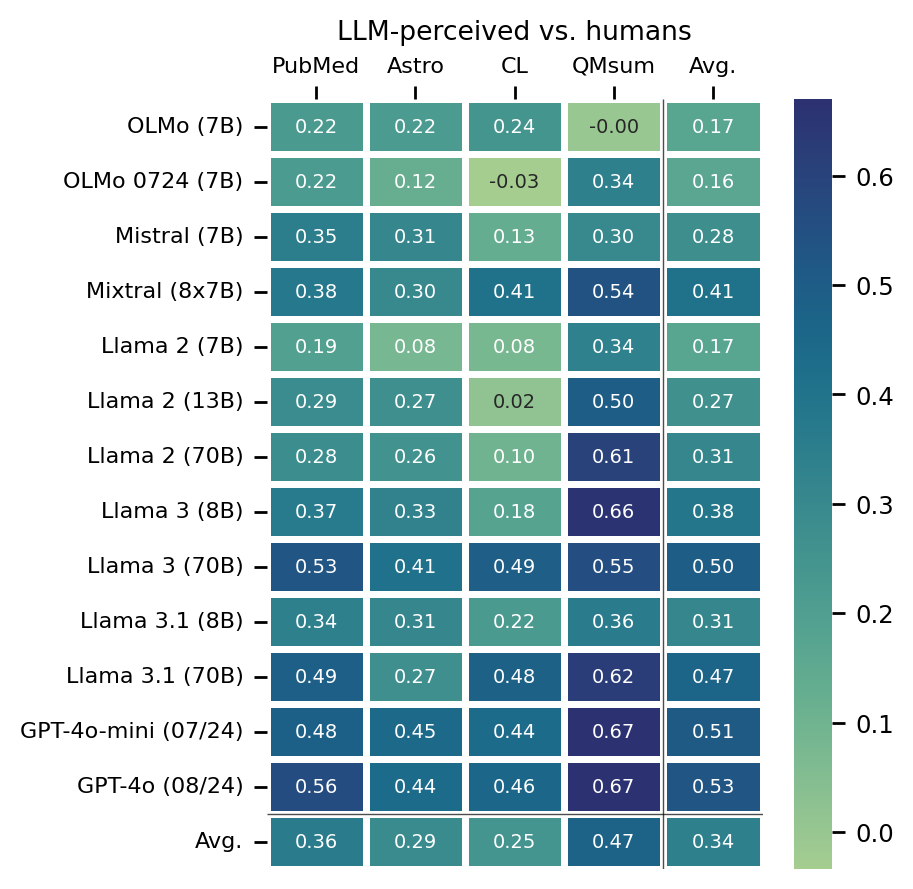

In [27]:
df = df_llm_perceived_vs_human.pivot(index='rater', columns='dataset', values='mean')
df = df.loc[rename_model.keys()][rename_dataset.keys()]
df = df.rename(rename_dataset, axis=1)
df = df.rename(index=rename_model)
df.loc['Avg.'] = df.mean(axis=0)
df['Avg.'] = df.mean(axis=1)

plot_heatmap(df)
plt.title('LLM-perceived vs. humans');

### LLM-observed vs. human

In [48]:
def llm_observed_vs_human(dataset, rater, debug=False):
    ratings_human =  df_ratings[(df_ratings['dataset'] == dataset) & (df_ratings['group'] == 'humans')].pivot(index='rater', columns='question_id', values='rating')

    ratings_model = df_ratings[
        (df_ratings['dataset'] == dataset) 
        & (df_ratings['group'] == 'llm_observed')
        & (df_ratings['rater'] == rater) 
    ].pivot(index=['rater', 'variant'], columns='question_id', values='rating')

    if ratings_model.empty:
        return None

    if debug:
        display(ratings_model)
        display(ratings_human)
    
    scores = pairwise_spearman(ratings_human.values, ratings_model.values)
    return scores

In [49]:
np.mean(llm_observed_vs_human('pubmed-sample', 'gpt-4o-2024-08-06', debug=True))

question_id                      0         1         2         3         4   \
rater             variant                                                     
gpt-4o-2024-08-06 0        0.788991  0.943478  0.541979  0.721512  0.848677   
                  1        0.772155   0.95169   0.53373   0.65888   0.84465   
                  2        0.788108  0.941984    0.5474  0.666351  0.836063   
                  3        0.810974   0.95698  0.535564  0.701817  0.845303   
                  4        0.775815  0.949968  0.560358  0.672505  0.833051   

question_id                      6         8         9         10        11  \
rater             variant                                                     
gpt-4o-2024-08-06 0        0.766436  0.774925  0.880896  0.885802  0.881931   
                  1        0.773754  0.755373  0.889398  0.888895  0.882953   
                  2        0.748403   0.76836  0.874857  0.870259  0.882503   
                  3        0.768318  0.761119  0.897561  0.879488  0.889894   
                  4        0.759711  0.751315  0.879646  0.870897  0.869954   

question_id                ...        18        19        20        23  \
rater             variant  ...                                           
gpt-4o-2024-08-06 0        ...  0.746535   0.81781  0.803854  0.825829   
                  1        ...  0.738934  0.823005  0.799576  0.810538   
                  2        ...  0.738724  0.821573  0.800175  0.815721   
                  3        ...  0.747645  0.819003   0.81414  0.827059   
                  4        ...  0.732933  0.814499  0.803552  0.822799   

question_id                      26        28        29        31        34  \
rater             variant                                                     
gpt-4o-2024-08-06 0        0.695274  0.756724   0.91095  0.868494  0.890191   
                  1        0.688814  0.761184  0.922173  0.866601  0.887407   
                  2        0.700753  0.751603  0.923528  0.865443  0.886677   
                  3        0.690951   0.78075  0.915697  0.871309  0.897782   
                  4        0.671038   0.76231   0.91128  0.865475  0.880743   

question_id                      36  
rater             variant            
gpt-4o-2024-08-06 0        0.868764  
                  1        0.871524  
                  2        0.869007  
                  3        0.870954  
                  4        0.864116  

[5 rows x 21 columns]

question_id,0,1,2,3,4,6,8,9,10,11,...,18,19,20,23,26,28,29,31,34,36
rater,,,,,,,,,,,,,,,,,,,,,
1gxc5yr,4,5,3,2,5,3,5,5,3,2,...,3,2,2,3,5,3,5,5,3,5
a4pjhcl,2,5,1,2,3,1,5,4,5,5,...,5,1,4,1,5,1,5,4,4,5
j42q3qe,3,4,3,4,3,4,5,5,5,4,...,3,4,4,4,5,3,5,4,5,5


0.24345233842248445

In [30]:
filtered = df_ratings[(df_ratings['group'] == 'llm_observed')]
datasets = filtered['dataset'].unique()
raters = filtered['rater'].unique()

stats = []
for dataset, rater in itertools.product(datasets, raters):
    scores = llm_observed_vs_human(dataset, rater)

    if not scores:
        print(f'n/a:', (dataset, rater))
        continue
    else:
        stats.append({
            'dataset': dataset,
            'rater': rater,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'raw': scores
        })

df_llm_observed_vs_human = pd.DataFrame(stats)
df_llm_observed_vs_human.head()

n/a: ('qmsum-generic', 'Meta-Llama-3-8B-Instruct')
n/a: ('qmsum-generic', 'Llama-2-13b-chat-hf')
n/a: ('qmsum-generic', 'Meta-Llama-3-70B-Instruct')
n/a: ('qmsum-generic', 'Llama-2-70b-chat-hf')
n/a: ('qmsum-generic', 'OLMo-7B-Instruct-hf')
n/a: ('qmsum-generic', 'Llama-2-7b-chat-hf')
n/a: ('qmsum-generic', 'OLMo-7B-0724-Instruct-hf')
n/a: ('qmsum-generic', 'gpt-4o-2024-08-06')


,dataset,rater,mean,std,raw
0,pubmed-sample,gpt-4o-mini-2024-07-18,0.336514,0.067423,"[0.25630879401308587, 0.2453729521351942, 0.27..."
1,pubmed-sample,Mixtral-8x7B-Instruct-v0.1,0.265242,0.026083,"[0.25494181377834946, 0.22418475849677916, 0.2..."
2,pubmed-sample,Meta-Llama-3-8B-Instruct,0.220799,0.068892,"[0.1476338653515375, 0.1476338653515375, 0.150..."
3,pubmed-sample,Llama-2-13b-chat-hf,0.259748,0.083807,"[0.3294422365714864, 0.37523607443515783, 0.37..."
4,pubmed-sample,Meta-Llama-3-70B-Instruct,0.226153,0.061876,"[0.1271291618304906, 0.14900084558627394, 0.20..."


### LLM-observed vs. Humans with baselines (barplot)

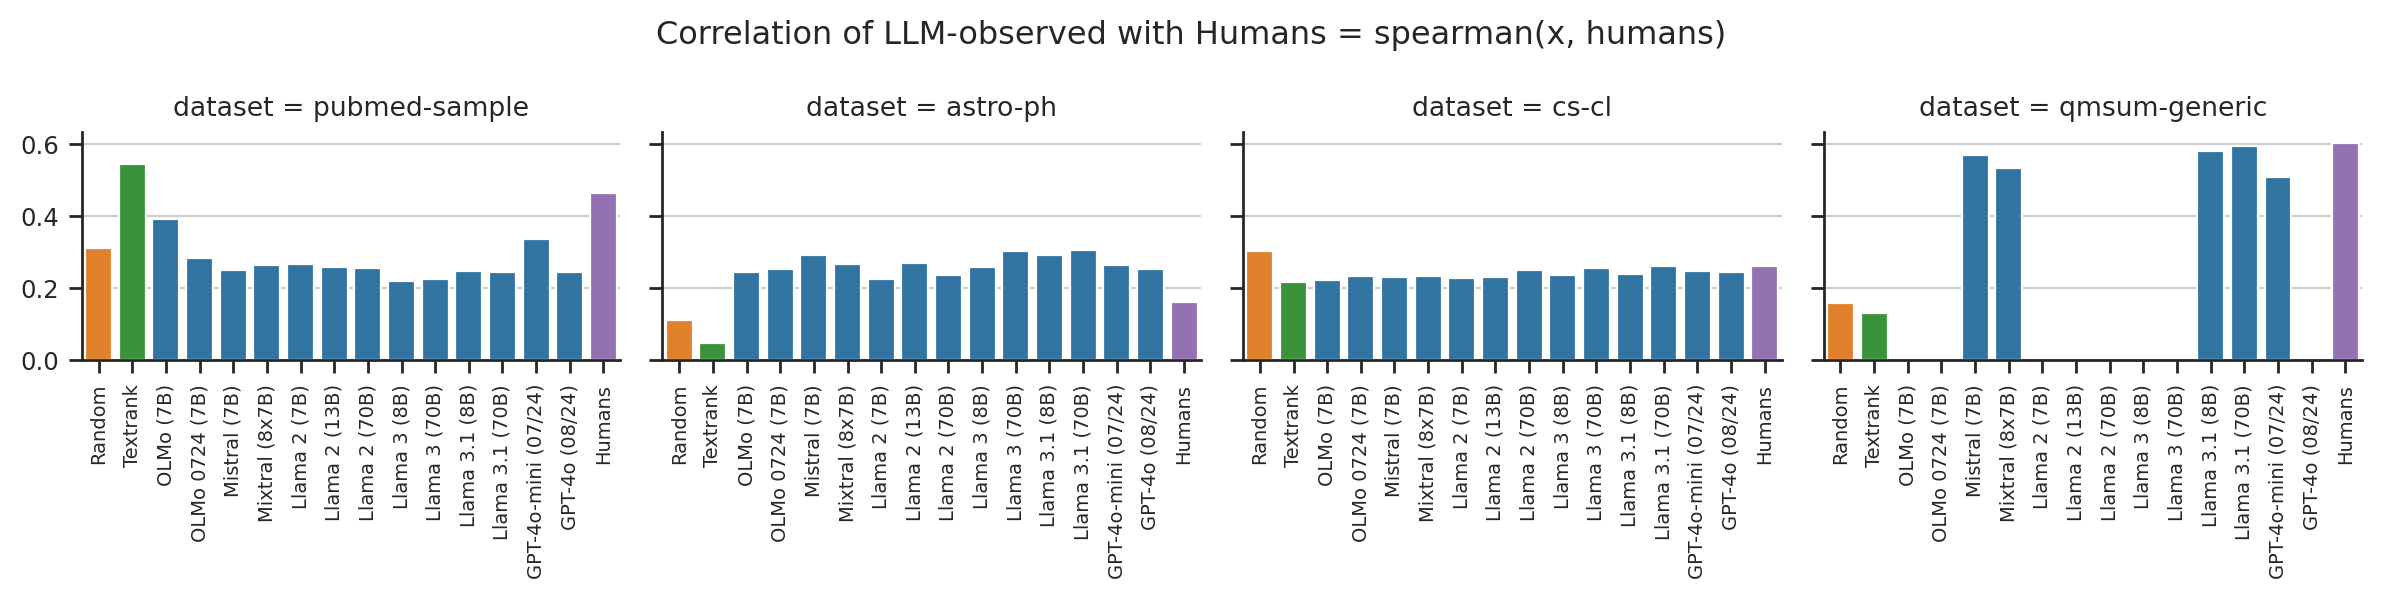

In [31]:
models = {
    'random': 'Random',
    'textrank': 'Textrank',
    'OLMo-7B-Instruct-hf': 'OLMo (7B)',
    'OLMo-7B-0724-Instruct-hf': 'OLMo 0724 (7B)',
    'Mistral-7B-Instruct-v0.3': 'Mistral (7B)',
    'Mixtral-8x7B-Instruct-v0.1': 'Mixtral (8x7B)',
    'Llama-2-7b-chat-hf': 'Llama 2 (7B)',
    'Llama-2-13b-chat-hf': 'Llama 2 (13B)',
    'Llama-2-70b-chat-hf': 'Llama 2 (70B)',
    'Meta-Llama-3-8B-Instruct': 'Llama 3 (8B)',
    'Meta-Llama-3-70B-Instruct': 'Llama 3 (70B)',
    'Meta-Llama-3.1-8B-Instruct': 'Llama 3.1 (8B)',
    'Meta-Llama-3.1-70B-Instruct': 'Llama 3.1 (70B)',
    'gpt-4o-mini-2024-07-18': 'GPT-4o-mini (07/24)',
    'gpt-4o-2024-08-06': 'GPT-4o (08/24)',
    'humans': 'Humans'
}

colors = {model: 'tab:blue' for model in models.values()}
colors['Random'] = 'tab:orange'
colors['Textrank'] = 'tab:green'
colors['Humans'] = 'tab:purple'

df_plot = df_llm_observed_vs_human[
    (df_llm_observed_vs_human['rater'].isin(models.keys()))
].copy()

human_human = df_human_human.copy()
human_human['rater'] = 'humans'
df_plot = pd.concat([df_plot, human_human])

df_plot['rater'] = df_plot['rater'].apply(lambda x: models[x])

sns.set_style("ticks",{'axes.grid' : True})
g = sns.catplot(df_plot, x='rater', y='mean', col='dataset', kind='bar', order=models.values(), hue='rater', palette=colors, height=3, col_order=['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic'])
g.tick_params(axis='x', rotation=90, labelsize=7)
g.set_xlabels('')
g.set_ylabels('')
plt.suptitle('Correlation of LLM-observed with Humans = spearman(x, humans)')
plt.tight_layout()

## Table

In [44]:
models_selection = {
    # 'humans': 'Humans',
    'random': 'Random',
    # 'textrank': 'Textrank',
    # 'OLMo-7B-Instruct-hf': 'OLMo (7B)',
    'OLMo-7B-0724-Instruct-hf': 'OLMo',
    # 'Mistral-7B-Instruct-v0.3': 'Mistral (7B)',
    'Mixtral-8x7B-Instruct-v0.1': 'Mixtral',
    # 'Llama-2-7b-chat-hf': 'Llama 2 (7B)',
    # 'Llama-2-13b-chat-hf': 'Llama 2 (13B)',
    # 'Llama-2-70b-chat-hf': 'Llama 2 (70B)',
    # 'Meta-Llama-3-8B-Instruct': 'Llama 3 (8B)',
    # 'Meta-Llama-3-70B-Instruct': 'Llama 3 (70B)',
    'Meta-Llama-3.1-8B-Instruct': 'Llama/8b',
    'Meta-Llama-3.1-70B-Instruct': 'Llama/70b',
    'gpt-4o-mini-2024-07-18': '4o-mini',
    'gpt-4o-2024-08-06': '4o',
    'Average': 'Avg.'
}
datasets_selection = {
    'pubmed-sample': 'PubMed',
    'astro-ph': 'Astro',
    'cs-cl': 'CL',
    'qmsum-generic': 'QMsum',
    'Average': 'Avg.'
}

In [45]:
dfs = [
    df_llm_perceived_self.pivot(index='dataset', columns='rater', values='mean'),
    df_llm_observed_self.pivot(index='dataset', columns='rater', values='mean'),
    df_llm_observed_vs_perceived.pivot(index='dataset', columns='rater', values='mean'),
    df_llm_perceived_vs_human.pivot(index='dataset', columns='rater', values='mean'),
    df_llm_observed_vs_human.pivot(index='dataset', columns='rater', values='mean'),
]
for df in dfs:
    df.loc['Average'] = df.mean(axis=0)
    df['Average'] = df.mean(axis=1)

df_all = pd.concat(dfs, keys=['LLM-perceived', 'LLM-observed', 'LLM-perceived vs. LLM-observed', 'LLM-perceived vs. Human', 'LLM-observed vs. Human'])
df_all = df_all \
    .reindex(datasets_selection.keys(), level=1)\
    .reindex(models_selection.keys(), axis=1)\
    .rename(index=datasets_selection, level=1)\
    .rename(models_selection, axis=1)

# colored version
# styled = df_all \
#     .style \
#     .background_gradient(axis=1, cmap='crest')\
#     .format(precision=3, na_rep='--')\
    
# display(styled)

# tex = styled.to_latex(convert_css=True)
# tex = tex.replace(r'{\cellcolor[HTML]{000000}} ', '')
# print(tex)

# black-white
df_all = df_all.rename_axis([None, None], axis=0).rename_axis(None, axis=1)
styled = df_all.round(2) \
    .style \
    .format(precision=2, na_rep='---') \
    .map_index(lambda v: "font-weight: bold;", axis="columns") \
    .map_index(lambda v: "font-weight: bold;", axis="rows", level=0) \
    .highlight_max(axis=1, props="font-weight:bold;")
display(styled)
tex = styled.to_latex(
    convert_css=True,
    environment='table*',
    position_float='centering',
    position='t',
    hrules=True
)
tex = tex.replace('\\centering', '\\small\n\\centering')
tex = tex.replace('\\multirow[c]{5}{*}', '\\multirow[c]{5}{0.14\\textwidth}')
print(tex)

\begin{table*}[t]
\small
\centering
\begin{tabular}{llrrrrrrrr}
\toprule
 &  & \bfseries Random & \bfseries OLMo & \bfseries Mixtral & \bfseries Llama/8b & \bfseries Llama/70b & \bfseries 4o-mini & \bfseries 4o & \bfseries Avg. \\
\midrule
\multirow[c]{5}{0.14\textwidth}{\bfseries LLM-perceived} & PubMed & -0.06 & 0.34 & 0.48 & 0.29 & 0.61 & 0.75 & \bfseries 0.80 & 0.43 \\
\bfseries  & Astro & 0.02 & 0.07 & 0.41 & 0.56 & 0.64 & 0.76 & \bfseries 0.86 & 0.46 \\
\bfseries  & CL & -0.10 & -0.05 & 0.65 & 0.29 & \bfseries 0.73 & 0.70 & 0.57 & 0.35 \\
\bfseries  & QMsum & -0.07 & 0.42 & 0.61 & 0.36 & \bfseries 0.87 & 0.72 & 0.80 & 0.55 \\
\bfseries  & Avg. & -0.05 & 0.20 & 0.54 & 0.37 & 0.71 & 0.73 & \bfseries 0.76 & 0.45 \\
\multirow[c]{5}{0.14\textwidth}{\bfseries LLM-observed} & PubMed & 0.94 & 0.98 & \bfseries 0.99 & \bfseries 0.99 & \bfseries 0.99 & \bfseries 0.99 & \bfseries 0.99 & 0.98 \\
\bfseries  & Astro & 0.91 & 0.99 & \bfseries 1.00 & 0.97 & 0.99 & 0.97 & 0.97 & 0.97 \\
\bfseries 

## Qualitative examples

| Question | Score LLM-observed | Score LLM-perceived | Score Human-perceived | Rationales Human | Rationales Model |

In [34]:
def aggregate_observed(dataset, rater):
    df_observed = df_ratings[
        (df_ratings['dataset'] == dataset)
        & (df_ratings['rater'] == rater)
        & (df_ratings['group'] == 'llm_observed')
    ].copy()
    df_observed['rating'] = df_observed['rating'].astype(float)
    
    # Min-Max Scaling for Observed Ratings
    min_obs, max_obs = df_observed['rating'].min(), df_observed['rating'].max()
    df_observed['scaled_rating'] = 1 + (df_observed['rating'] - min_obs) / (max_obs - min_obs) * 4
    df_observed = df_observed.groupby('question_id').agg(
        avg_rating_observed=('scaled_rating', 'mean')  # Use rescaled values
    )
    return df_observed


def aggregate_perceived(dataset, rater):
    df_perceived = df_ratings[
        (df_ratings['dataset'] == dataset)
        & (df_ratings['rater'] == rater)
        & (df_ratings['group'] == 'llm_perceived')
    ].copy()
    df_perceived['rating'] = df_perceived['rating'].astype(int)
    df_perceived = df_perceived.groupby('question_id').agg(
        avg_rating_perceived=('rating', 'mean'),
        ratings_perceived=('rating', list),
        rationales_perceived=('rationale', list)
    )
    return df_perceived


def aggregate_human(dataset):
    df_human = df_ratings[
        (df_ratings['dataset'] == dataset)
        & (df_ratings['group'] == 'humans')
    ].copy()
    df_human['rating'] = df_human['rating'].astype(int)
    df_human = df_human.groupby('question_id').agg(
        avg_rating_human=('rating', 'mean'),
        ratings_human=('rating', list),
        rationales_human=('rationale', list)
    )
    return df_human


def example_table(dataset, llm_rater):
    df_observed = aggregate_observed(dataset, llm_rater)
    df_perceived = aggregate_perceived(dataset, llm_rater)
    df_human = aggregate_human(dataset)
    
    df_combined = df_observed.merge(df_perceived, on='question_id', how='inner', validate="one_to_one")
    df_combined = df_combined.merge(df_human, on='question_id', how='inner', validate="one_to_one")

    df_questions = pd.read_json(f'../output/{dataset}/discord_questions.json')
    df_questions = df_questions.rename({'cluster_id': 'question_id', 'centroid': 'question'}, axis=1)
    df_questions = df_questions.set_index('question_id')

    df_combined = pd.merge(
        df_questions,
        df_combined,
        left_index=True,
        right_index=True
    )
    
    df_combined = df_combined.drop(['group_id', 'group_name'], axis=1)
    df_combined['rationales_perceived'] = df_combined['rationales_perceived'].apply(lambda x: '\n'.join(f'{i+1}. {r}' for i, r in enumerate(x)))
    df_combined['rationales_human'] = df_combined['rationales_human'].apply(lambda x: '\n'.join(f'{i+1}. {r}' for i, r in enumerate(x)))
    df_combined = df_combined.rename({
        'avg_rating_observed': 'avg. observed',
        'avg_rating_perceived': 'avg. perceived',
        'avg_rating_human': 'avg. human',
        'ratings_perceived': 'perceived',
        'ratings_human': 'human',
    }, axis=1)
    df_combined = df_combined.rename_axis(index='qid')
    df_combined = df_combined[['question', 'avg. observed', 'avg. perceived', 'avg. human', 'perceived', 'human', 'rationales_perceived', 'rationales_human']]
    df_combined = df_combined.sort_values('avg. observed', ascending=False)
    df_combined = df_combined.round(2)
    
    return df_combined

In [35]:
!mkdir -p ../output/qualitative

In [36]:
df = example_table('pubmed-sample', 'gpt-4o-2024-08-06')
df.to_csv('../output/qualitative/pubmed-ratings-rationales.csv')
df.head()

,question,avg. observed,avg. perceived,avg. human,perceived,human,rationales_perceived,rationales_human
qid,,,,,,,,
1,What is the main focus of the study?,4.92,5.0,4.67,"[5, 5, 5, 5, 5]","[5, 5, 4]",1. The main focus sets the context for the ent...,1. This determines whether a paper can be used...
29,What is the main outcome or effect observed?,4.62,5.0,5.00,"[5, 5, 5, 5, 5]","[5, 5, 5]",1. The main outcome is critical to understandi...,1. This determines whether a paper can be used...
14,What implications or future recommendations di...,4.62,3.6,2.00,"[4, 3, 4, 4, 3]","[1, 3, 2]",1. Implications and recommendations are import...,1. This is a job for the reader to decide for ...
34,What specific treatments were compared in the ...,4.35,4.2,4.00,"[4, 4, 5, 4, 4]","[3, 4, 5]",1. Knowing the treatments compared is crucial ...,"1. Specific treatments are useful, but are not..."
9,What condition is being addressed in the study?,4.31,5.0,4.67,"[5, 5, 5, 5, 5]","[5, 4, 5]",1. Identifying the condition is fundamental to...,1. This determines whether a paper can be used...


In [37]:
df = example_table('cs-cl', 'gpt-4o-2024-08-06')
df.to_csv('../output/qualitative/cs-cl-ratings-rationales.csv')
df.head()

,question,avg. observed,avg. perceived,avg. human,perceived,human,rationales_perceived,rationales_human
qid,,,,,,,,
15,What main topic is the document addressing?,4.98,5.0,4.6,"[5, 5, 5, 5, 5]","[5, 5, 3, 5, 5]",1. Understanding the main topic is crucial for...,1. Essential to tell the reader what the topic...
21,What significant results or conclusions does t...,4.36,4.0,3.4,"[4, 4, 2, 5, 5]","[4, 5, 4, 3, 1]",1. Significant results or conclusions are cruc...,"1. These are the main take-aways, so they are ..."
16,What are the broader implications or applicati...,4.32,3.0,2.6,"[3, 3, 2, 4, 3]","[2, 5, 1, 4, 1]",1. Broader implications help understand the st...,1. This often does not seem that informative (...
8,How does the study relate to previous research...,4.17,3.6,4.4,"[3, 3, 5, 3, 4]","[5, 4, 5, 3, 5]",1. Relating to previous research helps context...,1. The point of a Related Work section is to c...
19,What future research directions does the docum...,4.01,2.2,2.4,"[2, 2, 2, 2, 3]","[2, 2, 4, 3, 1]",1. Future directions are useful for understand...,1. This is not the kind of information I usual...


In [38]:
df = example_table('astro-ph', 'gpt-4o-2024-08-06')
df.to_csv('../output/qualitative/astro-ph-ratings-rationales.csv')
df.head()

,question,avg. observed,avg. perceived,avg. human,perceived,human,rationales_perceived,rationales_human
qid,,,,,,,,
0,What is the main focus of the study?,4.91,5.0,4.0,"[5, 5, 5, 5, 5]","[5, 4, 3, 5, 3]",1. The main focus is essential for understandi...,"1. I would include this information, this is e..."
17,What broader context or field does the study c...,4.64,3.4,2.4,"[3, 4, 4, 3, 3]","[3, 1, 4, 3, 1]",1. Understanding the broader context helps sit...,1. I would combine this with main focus. This ...
10,What specific phenomena or processes are being...,4.07,3.8,3.2,"[4, 3, 4, 4, 4]","[5, 4, 2, 4, 1]",1. Identifying the phenomena or processes prov...,"1. I feel this is the same as ""What is the mai..."
2,How do the findings affect the understanding o...,3.76,4.6,4.2,"[4, 4, 5, 5, 5]","[4, 4, 5, 3, 5]",1. This is crucial for assessing the study's i...,1. I think interpretation and implications of ...
15,What are the main findings of the study?,3.52,5.0,4.8,"[5, 5, 5, 5, 5]","[5, 5, 4, 5, 5]",1. The main findings are crucial for understan...,1. The key findings and evidence ca be the sam...


In [39]:
df = example_table('qmsum-generic', 'gpt-4o-mini-2024-07-18')
df.to_csv('../output/qualitative/qmsum-generic-ratings-rationales.csv')
df.head()

,question,avg. observed,avg. perceived,avg. human,perceived,human,rationales_perceived,rationales_human
qid,,,,,,,,
4,What main topic was discussed in the meeting?,4.89,5.0,5.0,"[5, 5, 5, 5, 5]","[5, 5, 5, 5, 5]",1. The main topic is foundational for understa...,1. makes sense\n2. The main topic is always th...
2,What were the main objectives or goals discuss...,3.90,4.4,4.6,"[5, 4, 5, 4, 4]","[5, 5, 4, 4, 5]",1. Understanding the main objectives is crucia...,1. relevant for an overall understanding \n2. ...
10,Which aspects of the main topic were covered i...,3.51,3.0,3.0,"[3, 3, 2, 3, 4]","[3, 3, 3, 3, 3]",1. Detailing aspects of the main topic can enh...,1. maybe not all aspects are relevant\n2. The ...
7,What were the anticipated impacts or implicati...,2.20,3.2,2.6,"[4, 3, 2, 3, 4]","[3, 3, 3, 1, 3]",1. Anticipated impacts provide insight into th...,"1. quite detailed info, I wouldn't necessarily..."
17,What were the major outcomes or decisions made...,2.16,4.8,5.0,"[5, 5, 4, 5, 5]","[5, 5, 5, 5, 5]",1. Outcomes and decisions are key to understan...,"1. it's important to know, without it the summ..."
